In [36]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [37]:
df = pd.read_pickle("../data/RDKit/rdkit_only_valid_smiles_qm9.pkl")
# Check the info of the dataframe, especially important is the dtypes of the columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129012 entries, 0 to 129011
Columns: 219 entries, MaxAbsEStateIndex to gaps
dtypes: float64(108), int64(110), object(1)
memory usage: 215.6+ MB
None


In [38]:
df.select_dtypes(include=[object])

,SMILES
0,[H]C([H])([H])[H]
1,[H]N([H])[H]
2,[H]O[H]
3,[H]C#C[H]
4,[H]C#N
...,...
129007,[H]C1([H])[C@@]23[N@H+]4[C@@]5([H])[C@]1([H])[...
129008,[H]C1([H])[C@@]2([H])[C@@]3([H])[C@@]14O[C@]1(...
129009,[H]C1([H])[N@@H+]2[C@@]3([H])[C@]2([H])[C@]2([...
129010,[H]C1([H])[N@H+]2[C@@]3([H])[C@@]14C([H])([H])...


Machine learning models can't generally handle strings (the SMILES of the molecules in our case).

Based on the type of data that is encoded in the string, the following optoins are available

- Categorical (small set of discrete values) $\rightarrow$ Use label encoding or one-hot encoding
- Text (sentences, descriptions, reviews, etc.) $\rightarrow$ Use text vectorization (TF-IDF, embeddings, etc.)
- IDs or identifiers (like user IDs, product codes) $\rightarrow$ Usually drop them, unless they carry domain meaning
- Mixed or corrupted data $\rightarrow$ Clean or cast to the proper type (e.g., numeric or datetime)

In our case, the SMILES act as IDs for the molecule, so we can drop them. This will not be a problem as the data of the SMILES is all encoded into the 217 features.

In [39]:
# Split features and target
X = df.drop(columns=['gaps', 'SMILES']) # Drop the target variable and the SMILES objects
y = df['gaps']

Create Stratification Bins

I have found two methods from pandas:
- Option A: Quantile bins, the number of elements in each bin will be roughly the same, but this will come at the cost of differently sized interval widths.
- Option B: pd.cut function, in which the bin edges were equal sized with uneven number of elements in each bin or group.

I think qcut is better

In [40]:
num_bins = 10  # 10 bins for deciles
gap_bins = pd.qcut(y, q=num_bins, labels=False)

In [41]:
# Stratified Train/Test Split
X_tv, X_test, y_tv, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=gap_bins
)

In [42]:
gap_bins_2 = pd.qcut(y_tv, q=num_bins, labels=False)

In [43]:
# Stratified Train/Validation Split
# X_train, X_validation, y_train, y_validation = train_test_split(
#     X_tv, y_tv,
#     test_size=0.06,
#     random_state=42,
#     stratify=gap_bins_2
# )

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

folds = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_tv, gap_bins_2)):
    X_train, X_val = X_tv.iloc[train_idx], X_tv.iloc[val_idx]
    y_train, y_val = y_tv.iloc[train_idx], y_tv.iloc[val_idx]

    folds.append({
        "fold": fold,
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val
    })

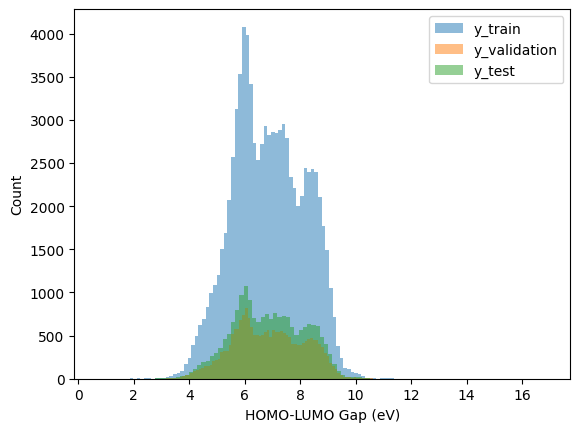

In [ ]:
# Verify the Stratification
# plt.hist(y_train, bins=100, alpha=0.5, label='y_train')
# plt.hist(y_val, bins=100, alpha=0.5, label='y_validation')
# plt.hist(y_test, bins=100, alpha=0.5, label='y_test')

# plt.xlabel('HOMO-LUMO Gap (eV)')
# plt.ylabel('Count')
# plt.legend()
# plt.show()